In [50]:
import os
import pickle

# Third-party
from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u
from astropy.table import Table
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from scipy.special import logsumexp
from scipy.optimize import minimize
from numba import jit

from pyia import GaiaData
from gala.mpl_style import laguna, hesperia

In [2]:
gc_frame = coord.Galactocentric(z_sun=0*u.pc, galcen_distance=8.1*u.kpc)

In [3]:
filename = '../data/rv-good-plx.fits'
g = GaiaData(filename)

c = g.skycoord
galcen = c.transform_to(gc_frame)

In [4]:
gal = c.galactic
gal.set_representation_cls('cartesian')

In [5]:
xyz = np.vstack((gal.u.to(u.pc).value, 
                 gal.v.to(u.pc).value,
                 gal.w.to(u.pc).value)).T

UVW = np.vstack((gal.U.to(u.km/u.s).value, 
                 gal.V.to(u.km/u.s).value, 
                 gal.W.to(u.km/u.s).value)).T

disk_vmask = np.linalg.norm(UVW, axis=1) < 200.

In [6]:
_cyl = gal.represent_as('cylindrical')
mask_r100 = (_cyl.rho < 100*u.pc) & (np.abs(_cyl.z) < 250*u.pc)
mask_r300 = (_cyl.rho < 300*u.pc) & (np.abs(_cyl.z) < 500*u.pc)
mask_r500 = (_cyl.rho < 500*u.pc) & (np.abs(_cyl.z) < 500*u.pc)
mask_r100.sum(), mask_r500.sum()

(165043, 1880612)

In [7]:
local_v = UVW[disk_vmask & mask_r100][::32]
local_x = xyz[disk_vmask & mask_r100][::32]

train_v = UVW[disk_vmask & mask_r300][::128]
train_x = xyz[disk_vmask & mask_r300][::128]

test_v = UVW[disk_vmask & mask_r300]
test_x = xyz[disk_vmask & mask_r300]

local_v.shape, train_v.shape, test_v.shape

((5140, 3), (8298, 3), (1062029, 3))

---

In [27]:
@jit('void(double[:,:], double[:,:], double[:,:,:])', nopython=True, nogil=True)
def pairwise_diff(a, b, diff):
    for i in range(len(a)):
        for j in range(len(b)):
            for k in range(3):
                diff[j,i,k] = a[i,k] - b[j,k]

In [16]:
def kde_obj(V, V_local, bw, delta):
    """Note: this is barely tested...by eye
    
    V : (n, 3)
    V_local : (m, 3)
    """
    # non-JIT version...
    # delta = V[None] - V_local[:, None] # (m, n, 3)
    pairwise_diff(V, V_local, delta)
    
    # objective function
    arg = -0.5 * np.sum(delta**2, axis=-1) / bw**2 # (m, n)
    scalar = logsumexp(arg, axis=0).sum()
    
    # gradient 
    _arg = arg - arg.max(axis=0)[None] # (m, n)
    exp_arg = np.exp(_arg)[..., None]
    grad = -np.sum(delta * exp_arg, axis=0) / np.sum(exp_arg, axis=0) / bw**2
    # grad = np.sum(-delta / bw**2 * exp_arg, axis=0) / np.sum(np.exp(_arg), axis=0)[..., None]
    
    return scalar, grad

In [34]:
def f_and_grad(p, V_train, X_train, V_local, bw, delta):
    aij = np.array(p[:9]).reshape(3, 3)
    bij = np.array(p[9:]).reshape(9, 3)

    VX_train = (V_train[:, None] * X_train[..., None]).reshape(-1, 9)
    s, g = kde_obj(V_train + X_train.dot(aij) + VX_train.dot(bij), 
                   V_local, bw, delta)

    grad = np.concatenate(((g[:, None] *  X_train[:, :, None]).sum(axis=0).reshape((9,)), 
                           (g[:, None] * VX_train[:, :, None]).sum(axis=0).reshape((27,))))

    return -s, -grad

In [83]:
class MySpace:
    
    def __init__(self, local_x, local_v, bw=3.):
        """
        Parameters
        ----------
        local_x : array_like
            3D Heliocentric Cartesian positions of the local
            stellar sample. Shape: (M, D) where D is probably 3.
        local_v : array_like
            3D Heliocentric Cartesian velocities of the local
            stellar sample. Shape: (M, D) where D is probably 3.
        bw : numeric (optional)
            The bandwidth (velocity smoothing scale in km/s) 
            used in constructing the KDE objective function.
        """
        self.local_x = np.array(local_x)
        self.local_v = np.array(local_v)
        assert self.local_x.shape == self.local_v.shape
        self.M, self.D = self.local_x.shape
        
        self.bw = float(bw)
        
        # set by .fit()
        self.N = None
        self.train_x = None
        self.train_v = None
        
        # TODO: this API sux
        self.A = None
        self.B = None
        # self.C = None ...
    
    def fit(self, train_x, train_v, x0=None):
        self.train_x = np.array(train_x)
        self.train_v = np.array(train_v)
        assert self.train_x.shape == self.train_v.shape
        self.N = self.train_x.shape[0]

        delta = np.zeros((self.M, self.N, self.D))
        
        # TODO: set the number of parameters automatically...
        if x0 is None:
            x0 = np.zeros(9 + 27)
            
        res = minimize(f_and_grad, x0=x0, 
                       method='L-BFGS-B', jac=True, 
                       args=(self.train_v, self.train_x, self.local_v, self.bw, delta))
        
        if not res.success:
            print("WARNING: failed to")
        
        self.A = np.array(res.x[:9]).reshape(3, 3)
        self.B = np.array(res.x[9:]).reshape(9, 3)
        return res
    
    def get_dv(self, x, v):
        if self.A is None:
            raise ValueError('Run .fit() first.')
            
        # TODO: not flexible...
        return (x.dot(self.A) + 
                (v[:, None] * x[..., None]).reshape(-1, 9).dot(self.B))
    
    def get_pred_v(self, x, v):
        return v + self.get_dv(x, v)

### Testing obj. function:

In [36]:
delta = np.zeros((len(local_v), len(train_v), 3))

In [37]:
# p = 1e-3 * np.random.random(size=9)
p = 1e-3 * np.random.random(size=9+27)
_s, _g = f_and_grad(p, train_v, train_x, local_v, 5., delta)

In [38]:
p2 = p.copy()
p2[17] += 1e-8
_s2, __ = f_and_grad(p2, train_v, train_x, local_v, 5., delta)

In [41]:
assert np.allclose((_s2 - _s) / 1e-8,
                   _g[17], rtol=1e-3)

## Running myspace:

In [61]:
if not os.path.exists('../cache/myspace.pkl'):
    myspace = MySpace(local_x, local_v)
    res = myspace.fit(train_x, train_v)

    with open('../cache/myspace.pkl', 'wb') as f:
        pickle.dump(myspace, f)
        
else:
    with open('../cache/myspace.pkl', 'rb') as f:
        myspace = pickle.load(f)

In [62]:
test_v_pred = myspace.get_pred_v(test_x, test_v)

(-125, 125)

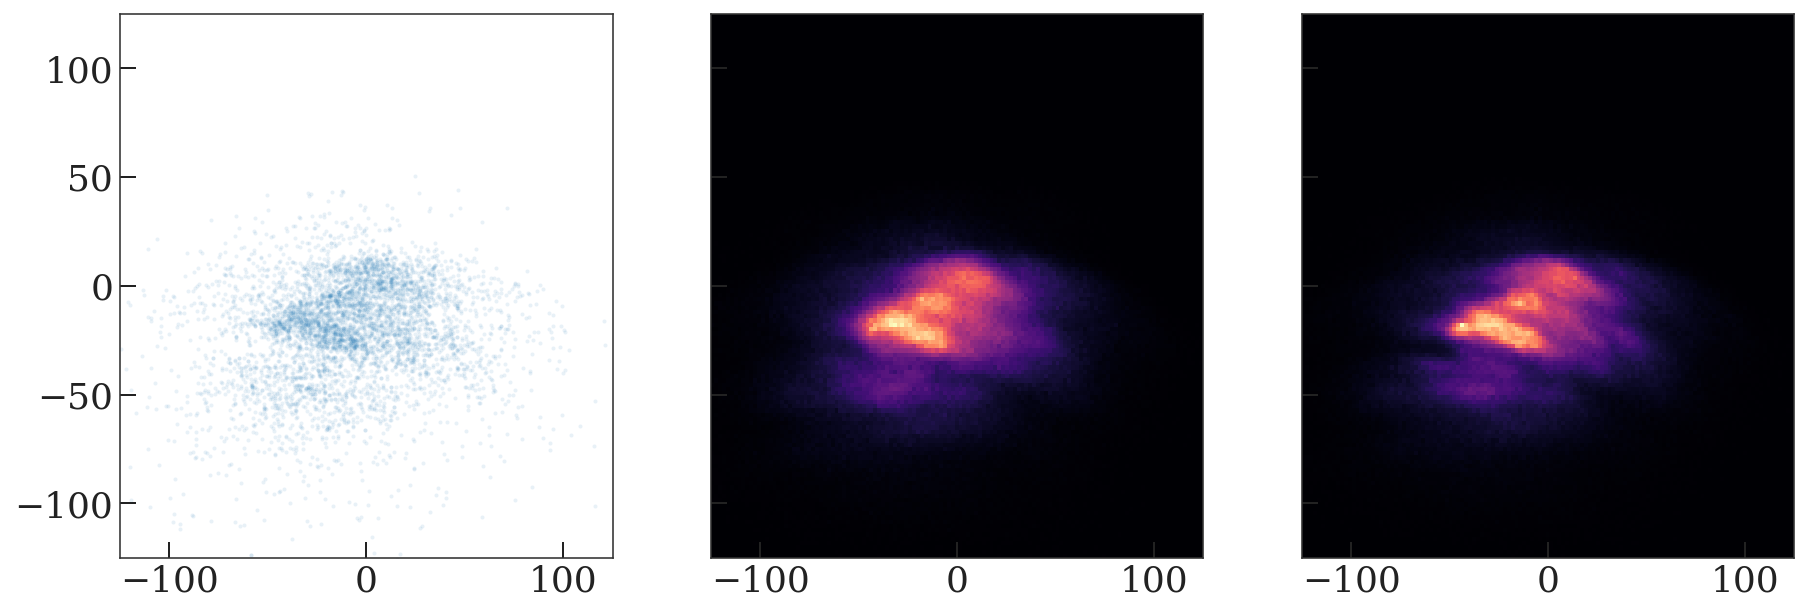

In [63]:
style = dict(marker='o', alpha=0.1, ms=2, ls='none', mew=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 5),
                         sharex=True, sharey=True)

axes[0].plot(local_v[:, 0], local_v[:, 1], **style)

bins = np.linspace(-125, 125, 128)
axes[1].hist2d(test_v[:, 0], test_v[:, 1], 
               bins=bins)
axes[2].hist2d(test_v_pred[:, 0], test_v_pred[:, 1], 
               bins=bins)

axes[0].set_xlim(-125, 125)
axes[0].set_ylim(-125, 125)

In [72]:
from scipy.ndimage import gaussian_filter

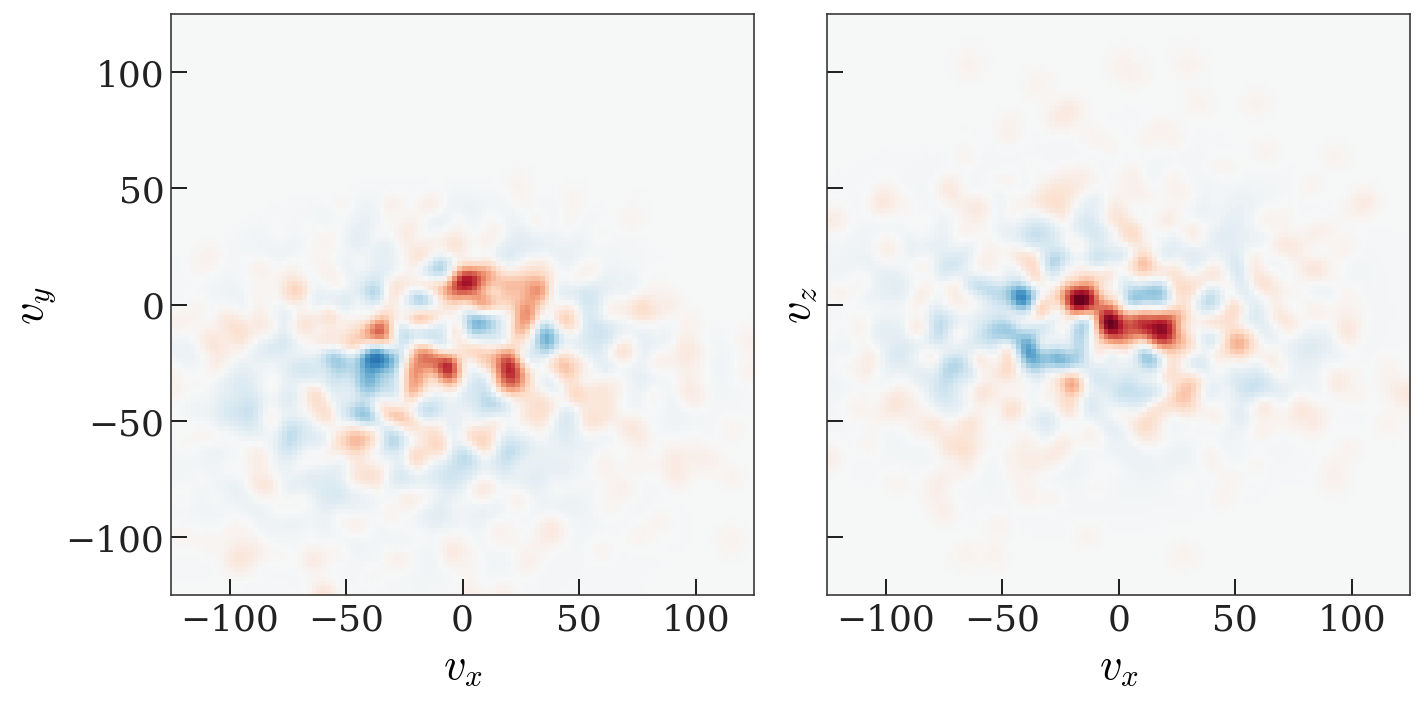

In [77]:
bins = np.linspace(-125, 125, 121)
_f = len(test_v) / len(local_v)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), 
                         sharex=True, sharey=True)

ax = axes[0]
H_test, xe, ye = np.histogram2d(local_v[:, 0], local_v[:, 1], bins=bins)
H_pred, xe, ye = np.histogram2d(test_v_pred[:, 0], test_v_pred[:, 1], bins=bins)
H_test = gaussian_filter(H_test, 2)
H_pred = gaussian_filter(H_pred, 2)
cc = ax.pcolormesh(xe, ye, (H_pred - _f * H_test).T,
                   cmap='RdBu', vmin=-200, vmax=200)
ax.set_xlabel('$v_x$')
ax.set_ylabel('$v_y$')


ax = axes[1]
H_test, xe, ye = np.histogram2d(local_v[:, 0], local_v[:, 2], bins=bins)
H_pred, xe, ye = np.histogram2d(test_v_pred[:, 0], test_v_pred[:, 2], bins=bins)
H_test = gaussian_filter(H_test, 2)
H_pred = gaussian_filter(H_pred, 2)
cc = ax.pcolormesh(xe, ye, (H_pred - _f * H_test).T,
                   cmap='RdBu', vmin=-200, vmax=200)

ax.set_xlabel('$v_x$')
ax.set_ylabel('$v_z$')

# fig.colorbar(cc)
fig.tight_layout()

### Refine training set:

Now we predict on the full training set to see which stars are pulled the least - this will help us define an even better local sample:

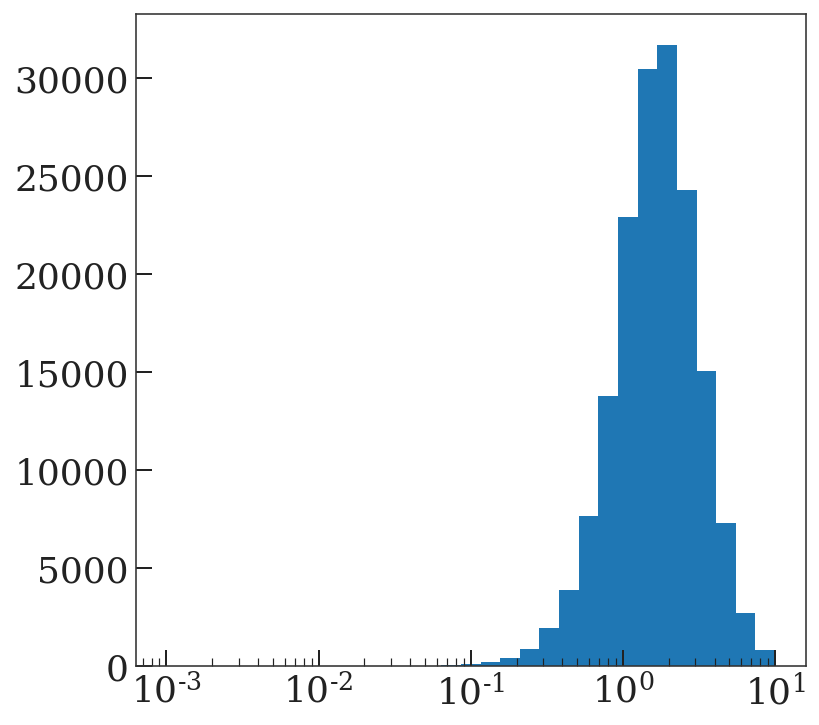

In [79]:
dv = myspace.get_dv(xyz[disk_vmask & mask_r100],
                    UVW[disk_vmask & mask_r100])
dv_mag = np.linalg.norm(dv, axis=1)

plt.hist(dv_mag, bins=np.logspace(-3, 1, 32));
plt.xscale('log')

In [80]:
new_local_x = UVW[disk_vmask & mask_r100][dv_mag < 1][::4]
new_local_v = UVW[disk_vmask & mask_r100][dv_mag < 1][::4]
len(new_local_x)

8407

In [ ]:
if not os.path.exists('../cache/myspace-iter1.pkl'):
    myspace_iter1 = MySpace(new_local_x, new_local_v)
    res = myspace_iter1.fit(train_x, train_v)

    with open('../cache/myspace-iter1.pkl', 'wb') as f:
        pickle.dump(myspace_iter1, f)
        
else:
    with open('../cache/myspace-iter1.pkl', 'rb') as f:
        myspace_iter1 = pickle.load(f)

# TODO: check if A is close to symmetric

In [36]:
UVW_fix = myspace_iter1.get_pred_v(xyz, UVW)

In [37]:
R_mask = (np.sqrt(xyz[:, 0]**2 + xyz[:, 1]**2) < 750.) & (np.abs(xyz[:, 2]) < 500)
close_mask = (np.sqrt(xyz[:, 0]**2 + xyz[:, 1]**2) < 150.) & (np.abs(xyz[:, 2]) < 200)

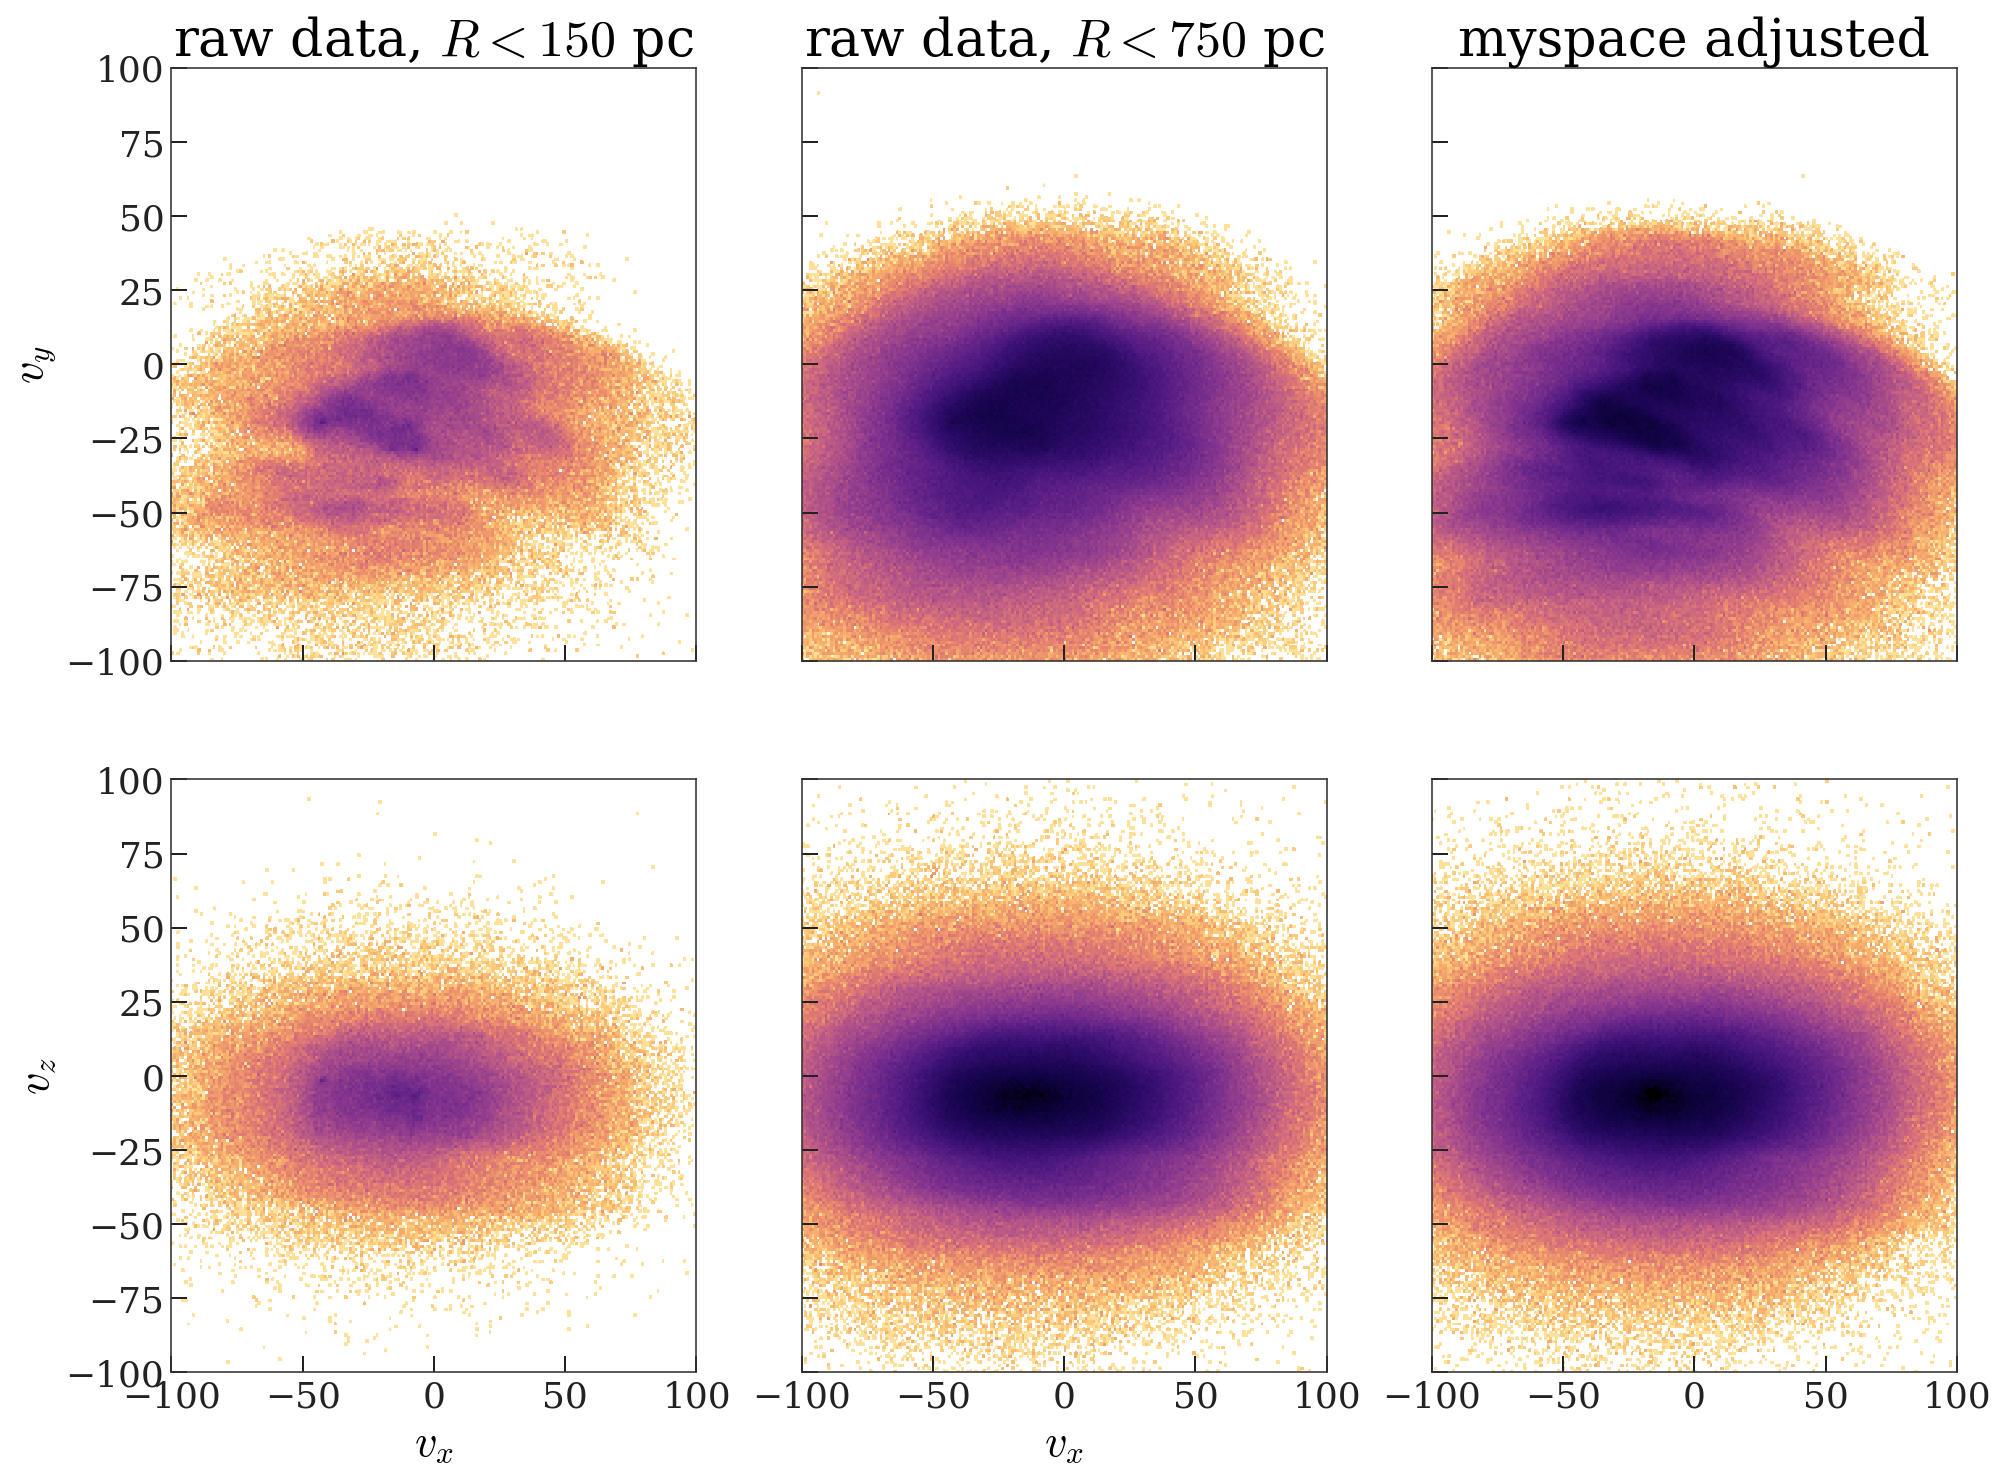

In [40]:
fig, all_axes = plt.subplots(2, 3, figsize=(16, 12),
                             sharex=True, sharey=True)

bins = np.arange(-100, 100+1e-3, 1)
style = dict(cmap='hesperia_r', norm=mpl.colors.LogNorm(1, 1e3))

axes = all_axes[0]

H, xe, ye = np.histogram2d(UVW[close_mask, 0], UVW[close_mask, 1],
                           bins=bins)
axes[0].pcolormesh(xe, ye, H.T, **style)

H, xe, ye = np.histogram2d(UVW[R_mask, 0], UVW[R_mask, 1],
                           bins=bins)
axes[1].pcolormesh(xe, ye, H.T, **style)

H, xe, ye = np.histogram2d(UVW_fix[R_mask, 0], UVW_fix[R_mask, 1],
                           bins=bins)
axes[2].pcolormesh(xe, ye, H.T, **style)

axes[0].set_title('raw data, $R < 150$ pc')
axes[1].set_title('raw data, $R < 750$ pc')
axes[2].set_title('myspace adjusted')

# axes[0].set_xlabel('$v_x$')
# axes[1].set_xlabel('$v_x$')
axes[0].set_ylabel('$v_y$')

axes = all_axes[1]
H, xe, ye = np.histogram2d(UVW[R_mask, 0], UVW[R_mask, 2],
                           bins=bins)
axes[1].pcolormesh(xe, ye, H.T, **style)

H, xe, ye = np.histogram2d(UVW_fix[R_mask, 0], UVW_fix[R_mask, 2],
                           bins=bins)
axes[2].pcolormesh(xe, ye, H.T, **style)

H, xe, ye = np.histogram2d(UVW_fix[close_mask, 0], UVW_fix[close_mask, 2],
                           bins=bins)
axes[0].pcolormesh(xe, ye, H.T, **style)

axes[0].set_xlabel('$v_x$')
axes[1].set_xlabel('$v_x$')
axes[0].set_ylabel('$v_z$')

fig.savefig('raw-vs-myspace-750.png', dpi=250)